In [249]:
from sklearn.cluster import KMeans
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids # install scikit-learn-extra
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [250]:
random_state = 42
data = pd.read_csv('output/loan.csv')
data

,Id,loan_date,loan_duration,loan_payments,Predicted,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,...,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent
0,5314,930705,12,8033,1.0,1,7,94812,15,13,...,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,45,3,0
1,5316,930711,36,4610,0.0,2,3,112709,48,20,...,52208.9,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,24,4,0
2,6863,930728,60,2118,0.0,2,3,77917,85,19,...,20272.8,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,57,5,0
3,5325,930803,36,2939,0.0,2,2,107870,84,29,...,34307.3,41297.480000,8253.080000,9254.600000,7168.100000,1371.704000,0,53,6,0
4,7240,930906,60,4579,0.0,1,4,1204953,0,0,...,41112.9,57188.211111,18945.966667,21255.930769,16801.000000,1522.707407,1,14,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,4989,981205,48,7348,NaN,2,6,103347,87,16,...,35875.3,30797.487500,8582.460714,8806.779310,8341.525926,538.846429,0,47,16,0
678,5221,981205,12,4376,NaN,2,0,157042,49,70,...,41035.4,59684.298851,12491.751724,14839.705263,10670.889796,471.668966,1,53,17,0
679,6402,981206,24,5812,NaN,1,2,75232,55,26,...,47956.3,46755.305769,13016.101923,17969.630769,10043.984615,461.121154,1,29,18,0
680,5346,981206,24,2318,NaN,2,1,285387,0,2,...,38449.2,29645.320175,6040.260526,7270.390000,5079.221875,337.274561,1,49,21,0


In [251]:
input_cols = [
    # Related to person
    'owner_male',
    'owner_age',

    # Related to account
    # 'account_frequency',
    # 'account_age_months',
    # 'has_disponent',
    'owner_card_type',

    # Related to district (choose 1: account_district XOR owner_district)

    'account_district_region',
    'account_district_no_inhabitants',
    # 'account_district_no_municipalities_0_499',
    # 'account_district_no_municipalities_500_1999',
    # 'account_district_no_municipalities_2000_9999',
    # 'account_district_no_municipalities_10000_plus',
    # 'account_district_no_cities',
    'account_district_ratio_urban_inhabitants',
    'account_district_average_salary',
    'account_district_unemployment_rate_95',
    # 'account_district_unemployment_rate_96',
    'account_district_no_enterpreneurs_per_1000_inhabitants',
    'account_district_no_crimes_95',
    # 'account_district_no_crimes_96',

    # 'owner_district_region',
    # 'owner_district_no_inhabitants',
    # 'owner_district_no_municipalities_0_499',
    # 'owner_district_no_municipalities_500_1999',
    # 'owner_district_no_municipalities_2000_9999',
    # 'owner_district_no_municipalities_10000_plus',
    # 'owner_district_no_cities',
    # 'owner_district_ratio_urban_inhabitants',
    # 'owner_district_average_salary',
    # 'owner_district_unemployment_rate_95',
    # 'owner_district_unemployment_rate_96',
    # 'owner_district_no_enterpreneurs_per_1000_inhabitants',
    # 'owner_district_no_crimes_95',
    # 'owner_district_no_crimes_96',

    # Related to transactions (I don't think we should use these for clustering)

    # 'count_trans_credits',
    # 'count_trans_withdrawals',
    # 'count_trans_credit_cash',
    # 'count_trans_withdrawal_cash',
    # 'count_trans_withdrawal_card',
    # 'count_trans_collection_other_bank',
    # 'count_trans_remittance_other_bank',
    # 'count_trans_ksymbol_interest_credited',
    # 'count_trans_ksymbol_household',
    # 'count_trans_ksymbol_payment_for_statement',
    # 'count_trans_ksymbol_insurance_payment',
    # 'count_trans_ksymbol_sanction_interest_if_negative_balance',
    # 'count_trans_ksymbol_oldage_pension',
    # 'last_trans_balance',
    # 'mean_trans_balance',
    # 'mean_trans_amount_absolute',
    # 'mean_trans_amount_credit',
    # 'mean_trans_amount_withdrawal',
    # 'mean_trans_amount_signed',
]

data[input_cols]

,owner_male,owner_age,owner_card_type,account_district_region,account_district_no_inhabitants,account_district_ratio_urban_inhabitants,account_district_average_salary,account_district_unemployment_rate_95,account_district_no_enterpreneurs_per_1000_inhabitants,account_district_no_crimes_95
0,0,45,0,7,94812,0.818,9650,0.0338,0.100,0.031483
1,1,24,0,3,112709,0.735,8369,0.0179,0.117,0.025322
2,1,57,0,3,77917,0.535,8390,0.0228,0.132,0.026695
3,0,53,0,2,107870,0.580,8754,0.0383,0.137,0.035265
4,1,14,0,4,1204953,1.000,12541,0.0029,0.167,0.071104
...,...,...,...,...,...,...,...,...,...,...
677,0,47,1,6,103347,0.670,9104,0.0151,0.123,0.022245
678,1,53,0,0,157042,0.339,8743,0.0188,0.111,0.023299
679,1,29,0,2,75232,0.417,8980,0.0195,0.111,0.037537
680,1,49,0,1,285387,0.899,10177,0.0663,0.081,0.034613


In [252]:
data['account_district_no_inhabitants'] = np.log(data['account_district_no_inhabitants'])
data['account_district_average_salary'] = np.log(data['account_district_average_salary'])

In [253]:
def calculate_inputs(pca=False):
    inputs = data[input_cols].values
    scaler = StandardScaler().fit(inputs)
    inputs = scaler.transform(inputs)

    if pca:
        pca = PCA(n_components=2, random_state=random_state)
        pca.fit(inputs)
        inputs = pca.transform(inputs)
    
    return inputs

def run_model(model, params, metric='euclidean'):
    """
    A more convenient wrapper around train_and_evaluate, albeit less general.
    """
    inputs = calculate_inputs()
    clf = model(**params)
    clf = clf.fit(inputs)

    labels = clf.labels_

    sns.scatterplot(x=inputs[:, 0], y=inputs[:, 1], hue=clf.labels_, palette='Set1')
    plt.show()
    
    silhouettes = silhouette_samples(inputs, labels, metric=metric)

    # order inputs, labels, silhouettes by labels, then by silhouettes
    inputs = inputs[np.lexsort((silhouettes, labels))]
    labels = labels[np.lexsort((silhouettes, labels))]
    silhouettes = silhouettes[np.lexsort((silhouettes, labels))]

    # plot the silhouette scores for each sample
    x = np.arange(len(inputs))
    plt.figure(figsize=(20, 10))
    plt.bar(x, silhouettes, width=0.5)
    plt.title('Silhouette scores')
    plt.show()

    print(f"Average silhouette score: { {i: silhouettes[labels == i].mean() for i in range(clf.n_clusters)} }")
    print(f"Total average silhouette score: {np.mean(silhouettes)}")

    # The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
    print(f"Variance Ratio Criterion: {calinski_harabasz_score(inputs, labels)}") 

    # The score is defined as the average similarity measure of each cluster with its most similar cluster, 
    # where similarity is the ratio of within-cluster distances to between-cluster distances. 
    # Thus, clusters which are farther apart and less dispersed will result in a better score.
    print(f"Davies-Bouldin score: {davies_bouldin_score(inputs, labels)}")
    
    return clf

def figure_out_best_k(model, params, metric='euclidean', min_clusters=2, max_clusters=10):
    """
    This unfortunately cannot be done automatically, must choose manually after interpreting the graphs.
    """    
    inputs = calculate_inputs()

    clf = model(**params)

    visualizer = KElbowVisualizer(clf, k=(min_clusters, max_clusters), distance_metric=metric, timings=False)
    visualizer.fit(inputs)
    visualizer.show()

    silhouettes = []
    K = range(min_clusters, max_clusters)
    for k in K:
        clf = model(**params, n_clusters=k)
        clf.fit(inputs)
        silhouettes.append(silhouette_score(inputs, clf.labels_, metric=metric))

    best_k_silhouette = np.argmax(silhouettes) + min_clusters

    plt.figure(figsize=(4,2))
    plt.plot(K, silhouettes, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average silhouette width')
    plt.title('Silhouette-based Method showing the optimal k')
    plt.show()
 
    return visualizer.elbow_value_, best_k_silhouette

def use_model(model, params=None, metric='euclidean', min_clusters=2, max_clusters=10):
    if params is None:
        params = {}
    
    print("Finding best k...")
    elbow, silhouette = figure_out_best_k(model, params, metric, min_clusters, max_clusters)
    print("=========================================")
    print(f"Using best k from elbow method: {elbow}")
    run_model(model, {**params, 'n_clusters': elbow}, metric)
    print("=========================================")
    print(f"Using best k from silhouette method: {silhouette}")
    run_model(model, {**params, 'n_clusters': silhouette}, metric)


Finding best k...


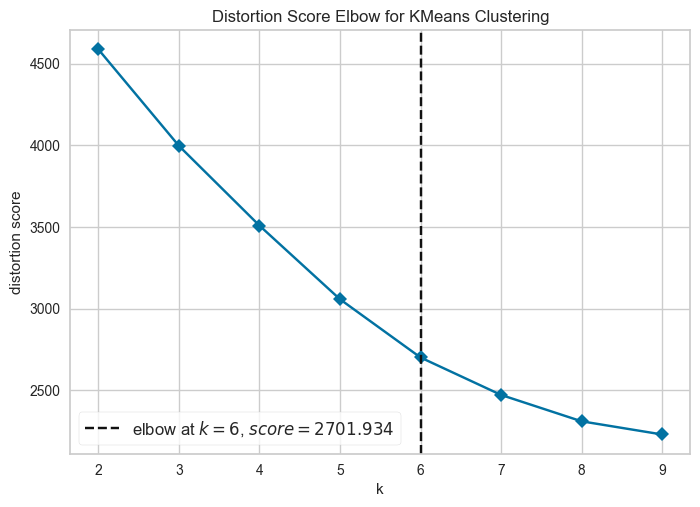

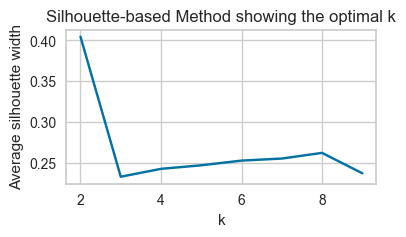

Using best k from elbow method: 6


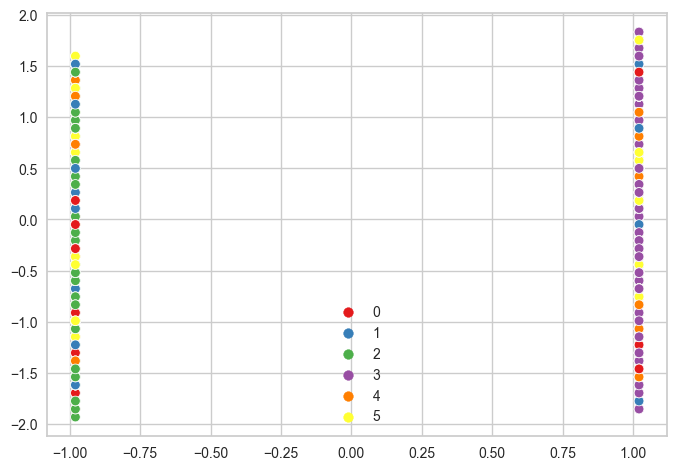

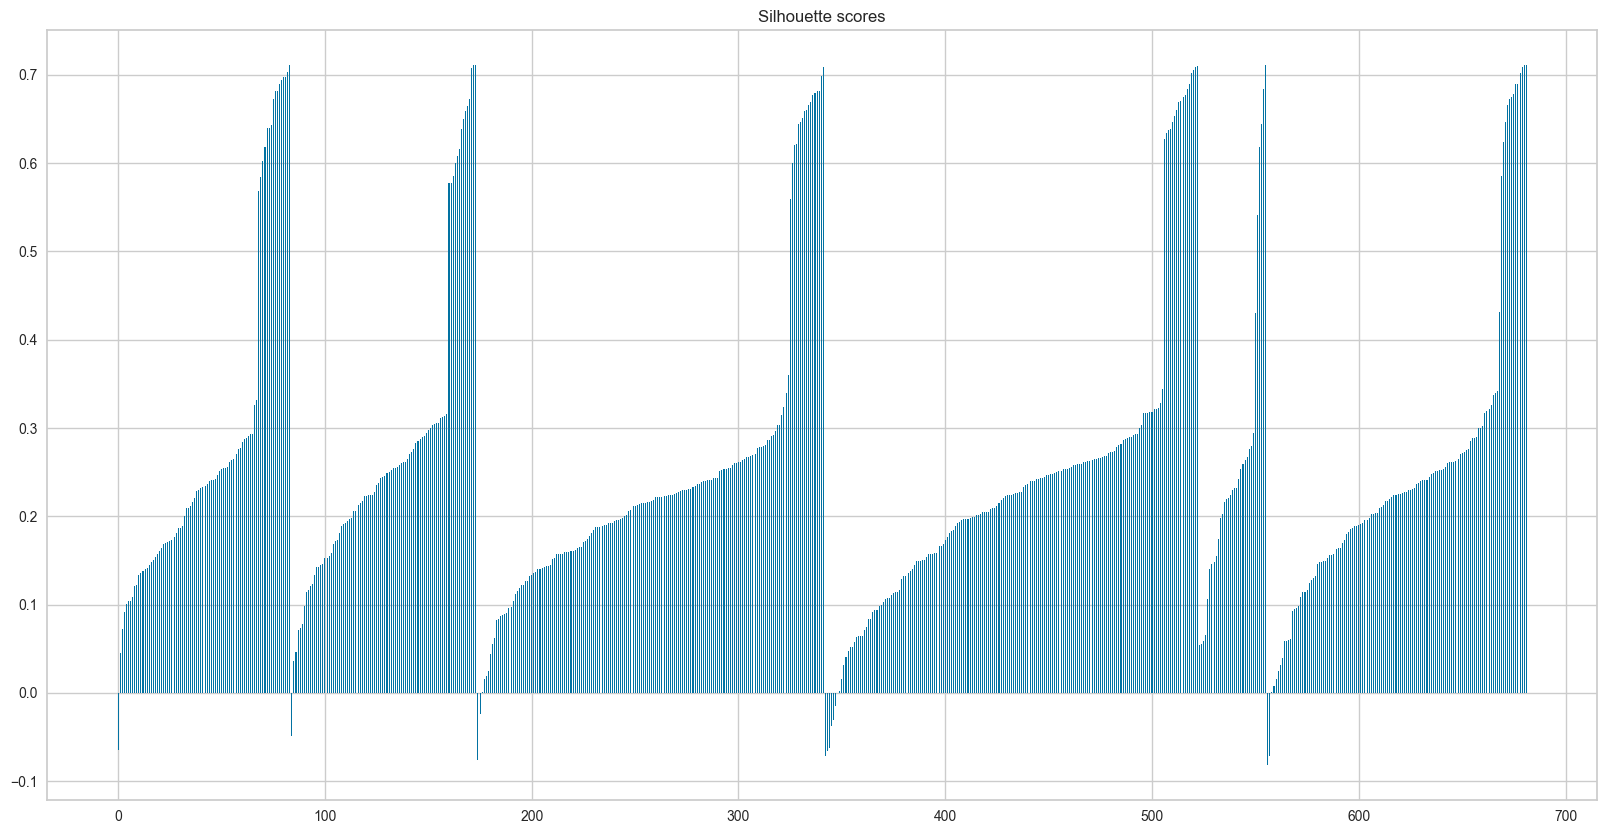

Average silhouette score: {0: 0.2859794602699243, 1: 0.2782413214117218, 2: 0.24061428834491452, 3: 0.23666819248922225, 4: 0.267809360321988, 5: 0.24624499744384742}
Total average silhouette score: 0.2524761223471757
Variance Ratio Criterion: 206.0606960711205
Davies-Bouldin score: 1.402615548187273
Using best k from silhouette method: 2


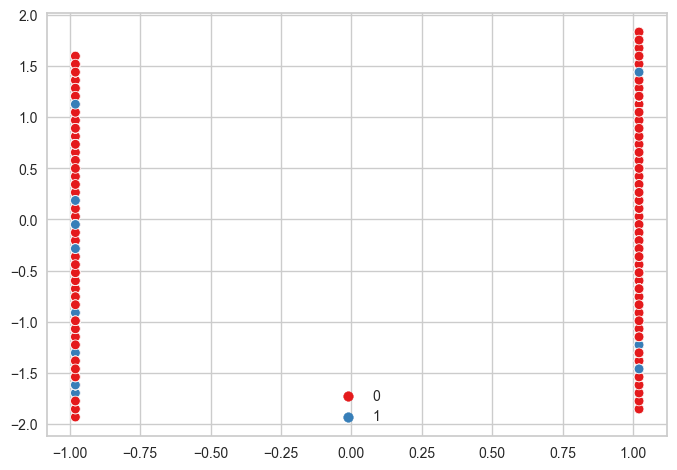

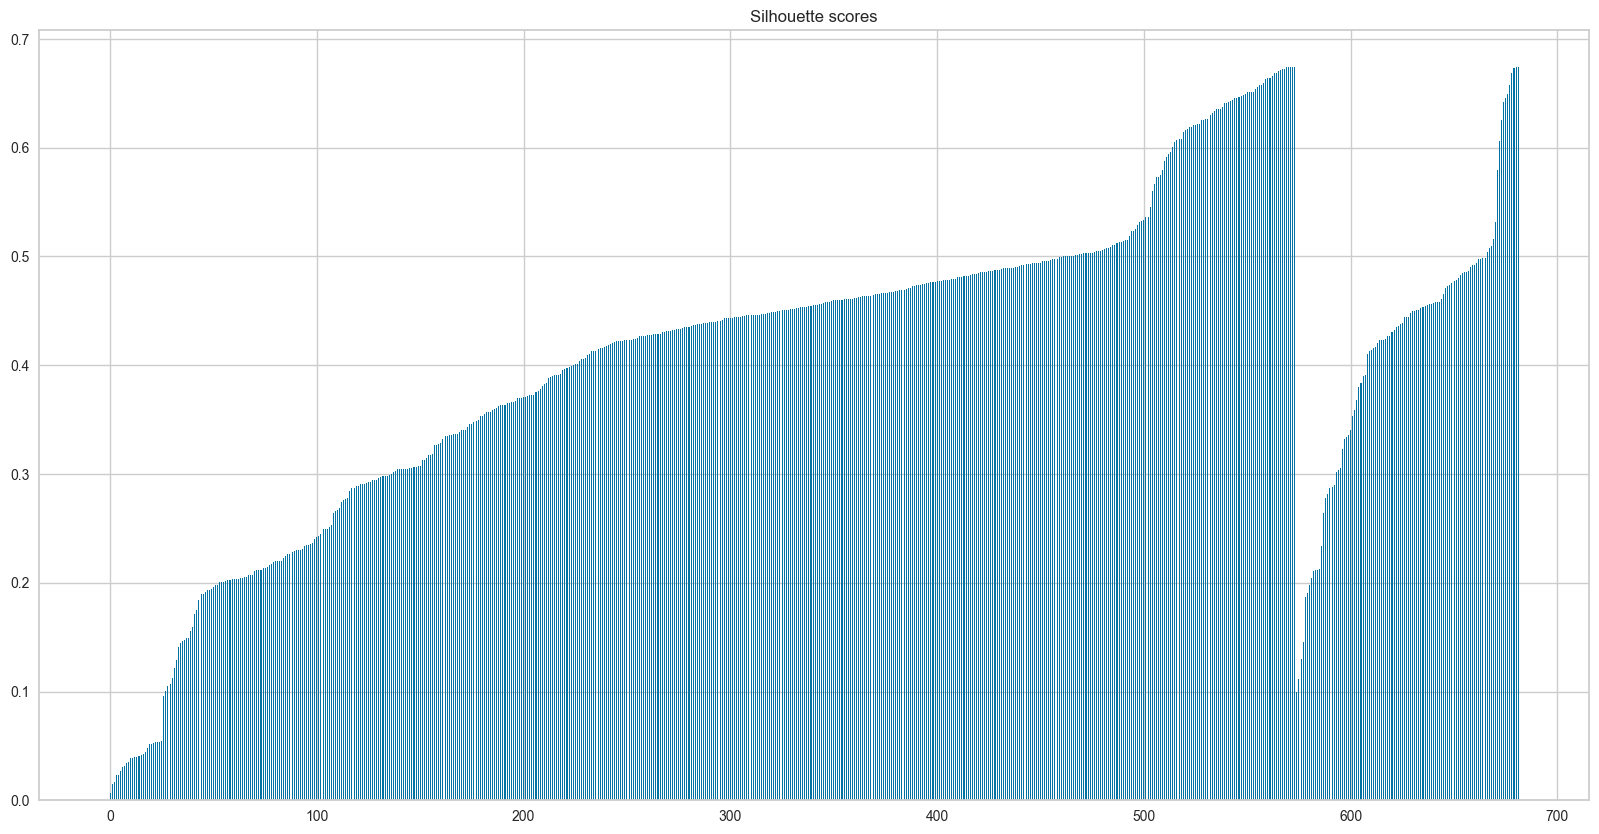

Average silhouette score: {0: 0.40172466760089015, 1: 0.41979424247133357}
Total average silhouette score: 0.4045861252050072
Variance Ratio Criterion: 331.0412696477279
Davies-Bouldin score: 0.9003203261076651


In [254]:
use_model(KMeans, {'random_state': random_state}, metric='euclidean')


Finding best k...


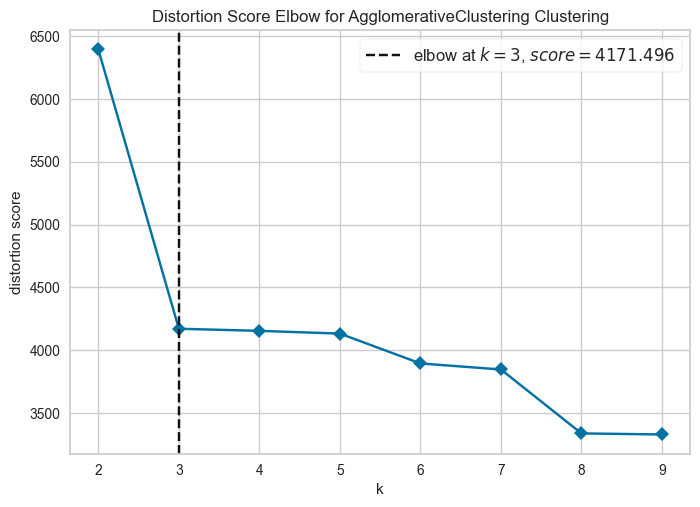

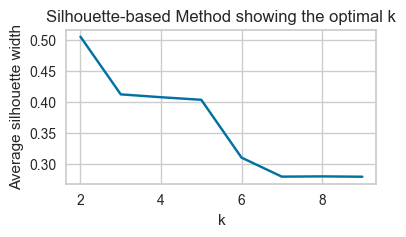

Using best k from elbow method: 3


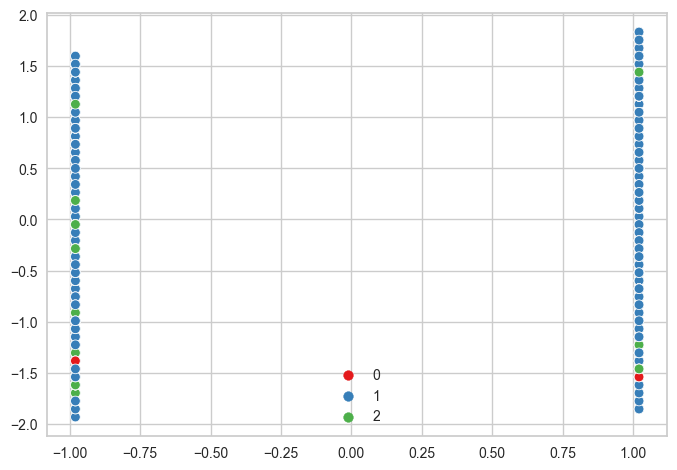

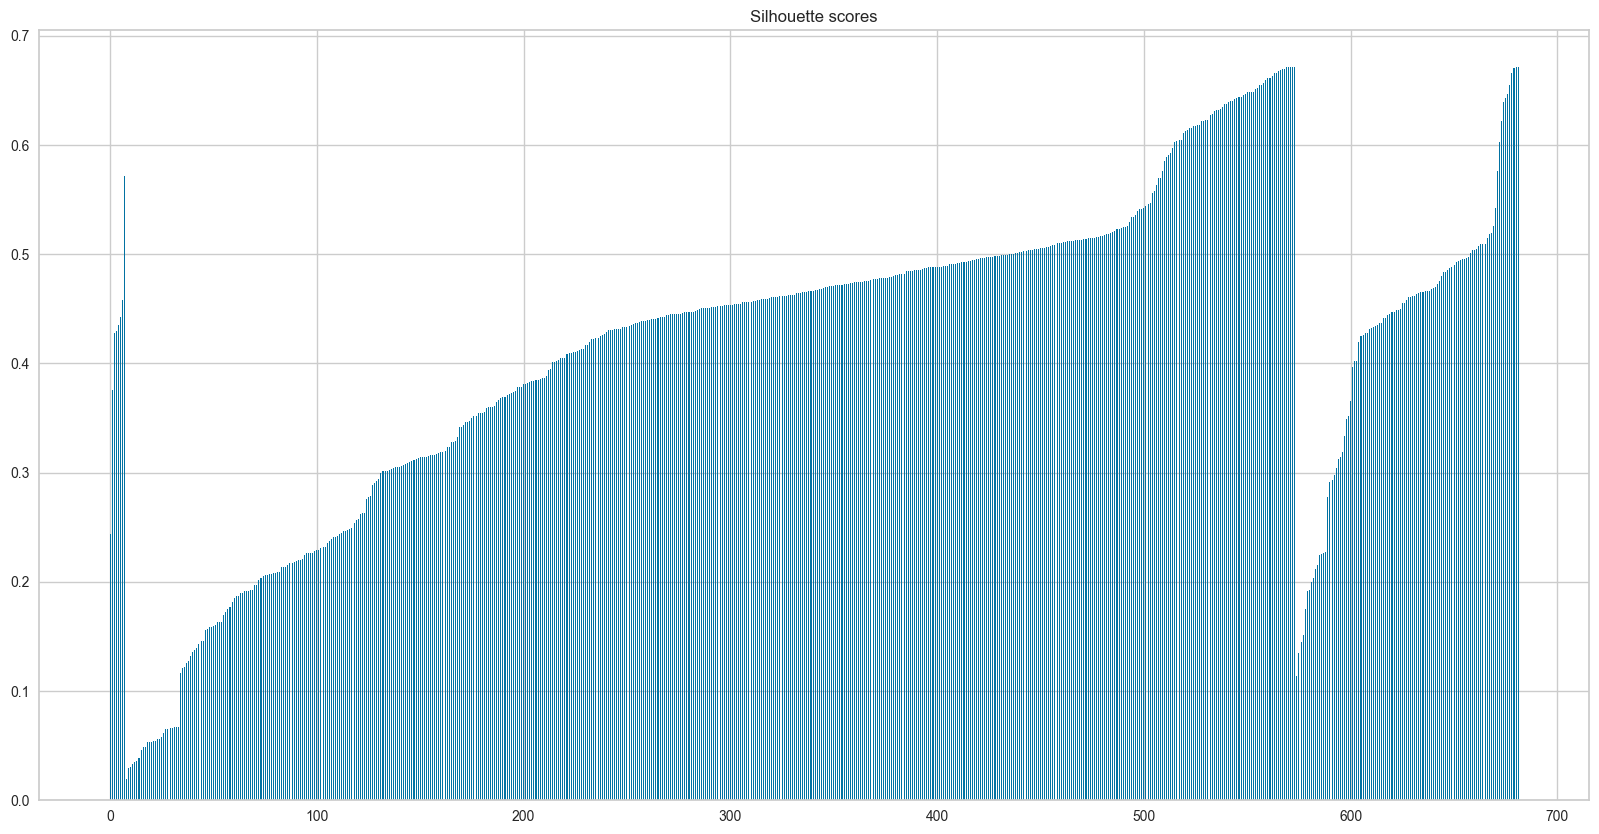

Average silhouette score: {0: 0.4231771358642162, 1: 0.4087186641520361, 2: 0.4302093721609496}
Total average silhouette score: 0.41229148561634715
Variance Ratio Criterion: 215.55021663399003
Davies-Bouldin score: 0.8289972268234634
Using best k from silhouette method: 2


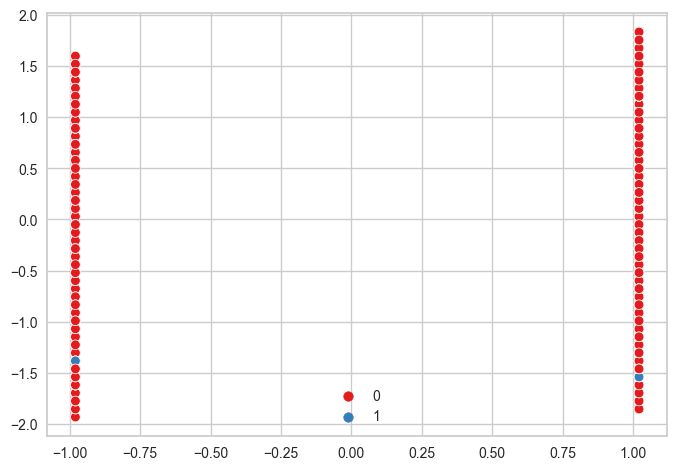

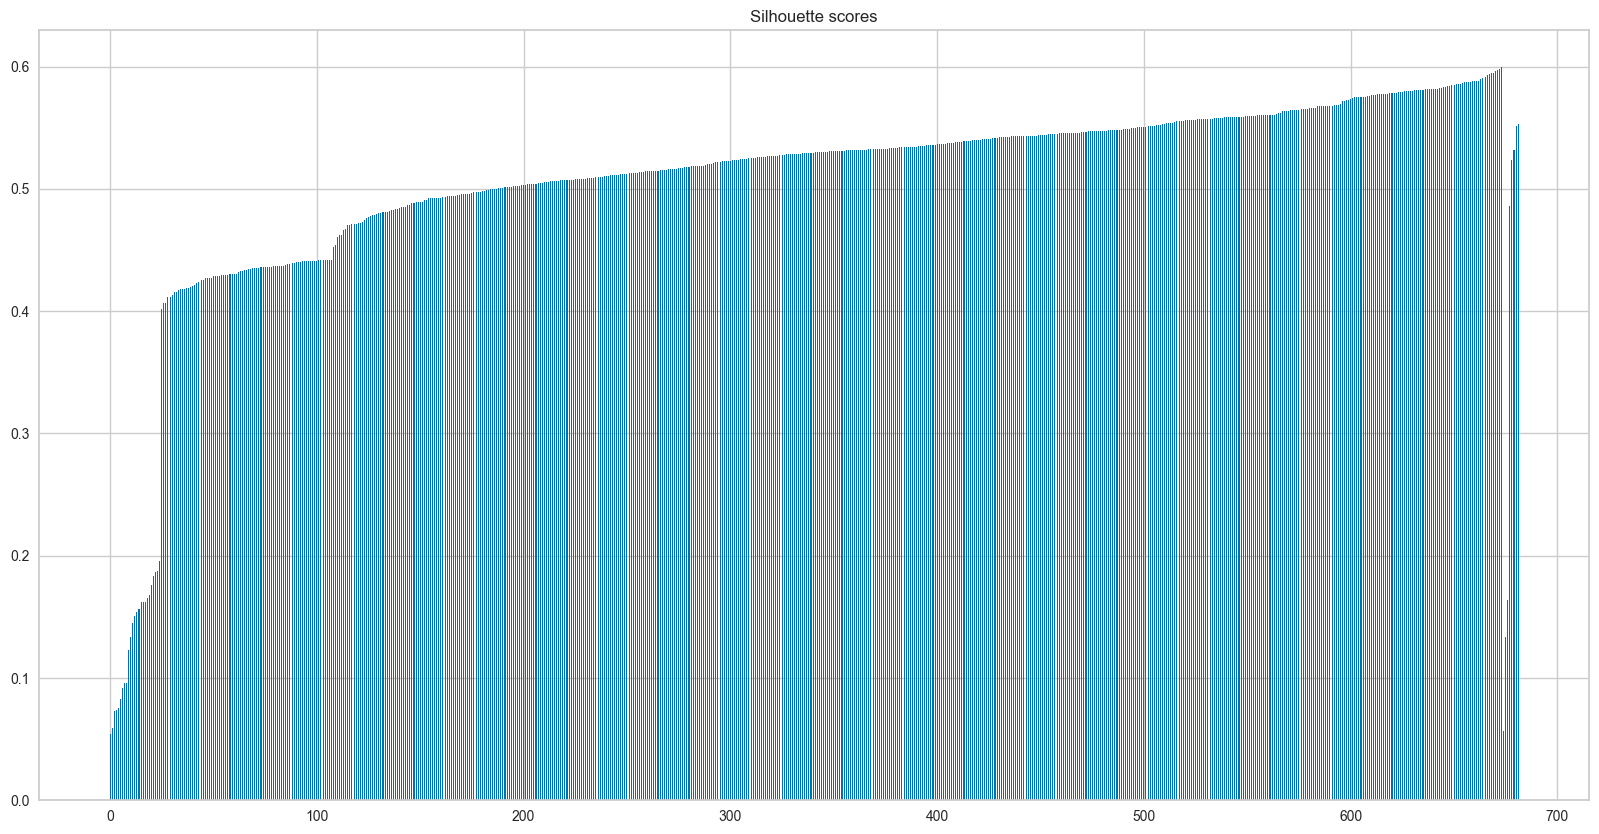

Average silhouette score: {0: 0.5070140871780109, 1: 0.3749801742333435}
Total average silhouette score: 0.5054653022754342
Variance Ratio Criterion: 45.38345707325108
Davies-Bouldin score: 0.7664305333600224


In [255]:
use_model(AgglomerativeClustering, {'linkage': 'average'}, metric='euclidean')

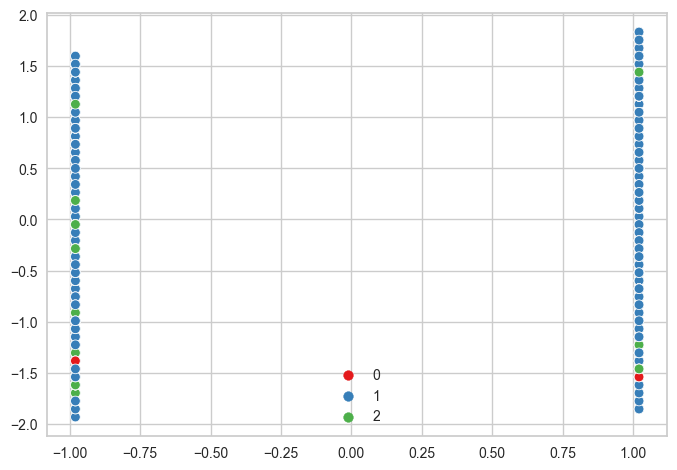

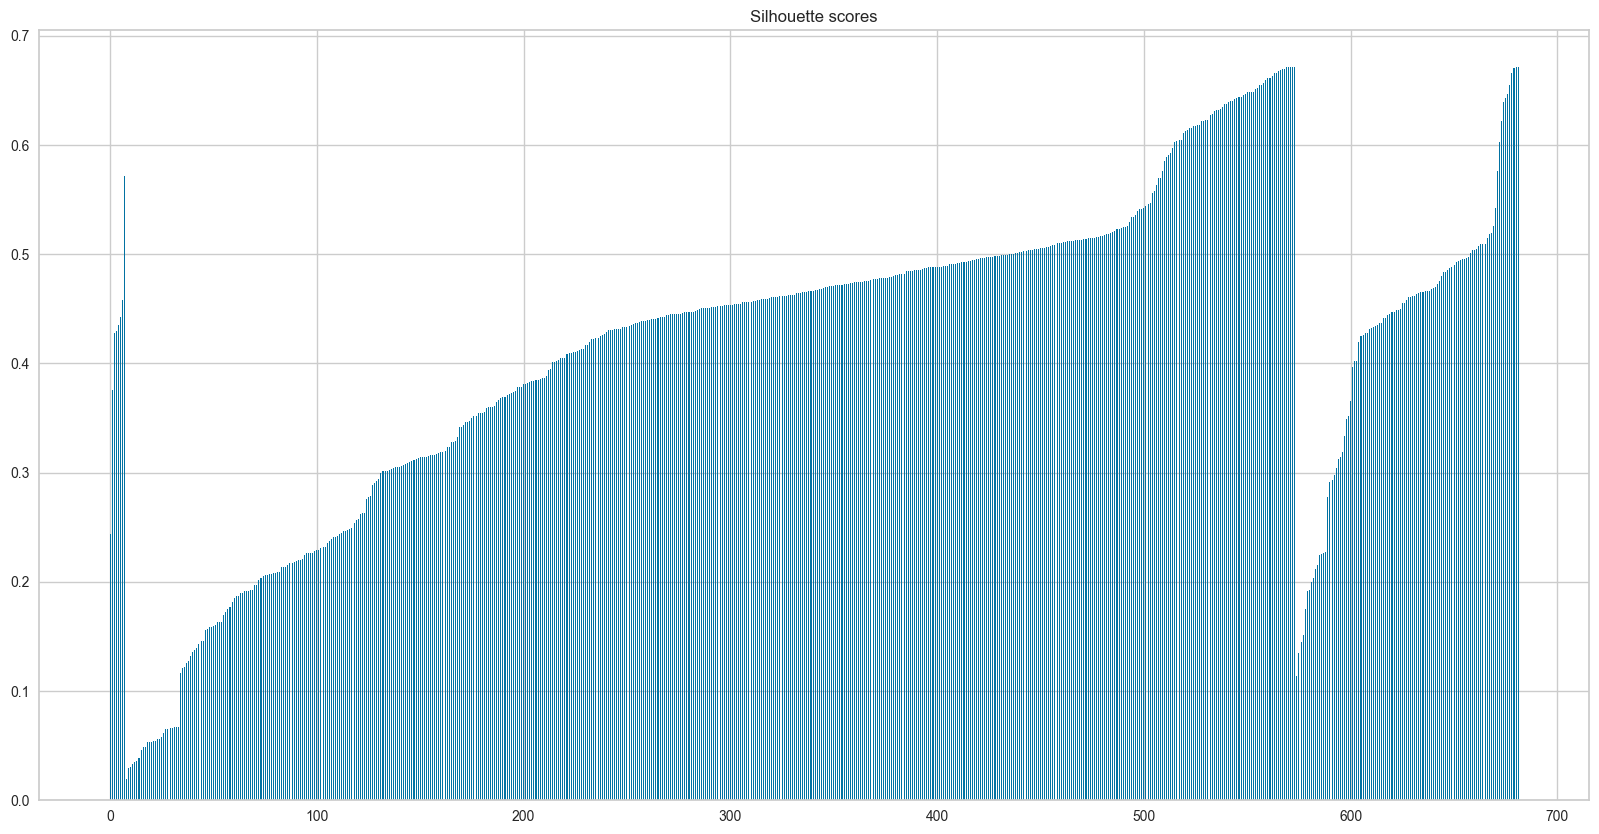

Average silhouette score: {0: 0.4231771358642162, 1: 0.4087186641520361, 2: 0.4302093721609496}
Total average silhouette score: 0.41229148561634715
Variance Ratio Criterion: 215.55021663399003
Davies-Bouldin score: 0.8289972268234634


In [256]:
# clf = run_model(AgglomerativeClustering, {'linkage': 'average', 'n_clusters': 5}, metric='euclidean')
clf = run_model(AgglomerativeClustering, {'linkage': 'average', 'n_clusters': 3}, metric='euclidean')
data['owner_profile'] = clf.labels_

Finding best k...


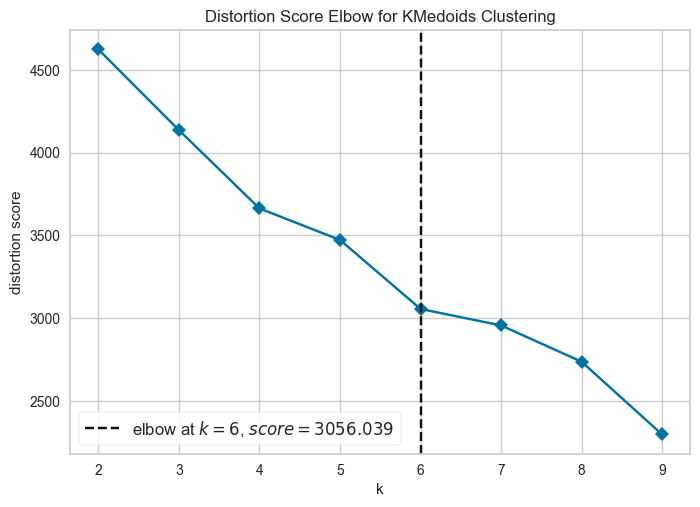

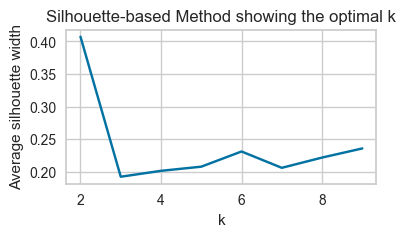

Using best k from elbow method: 6


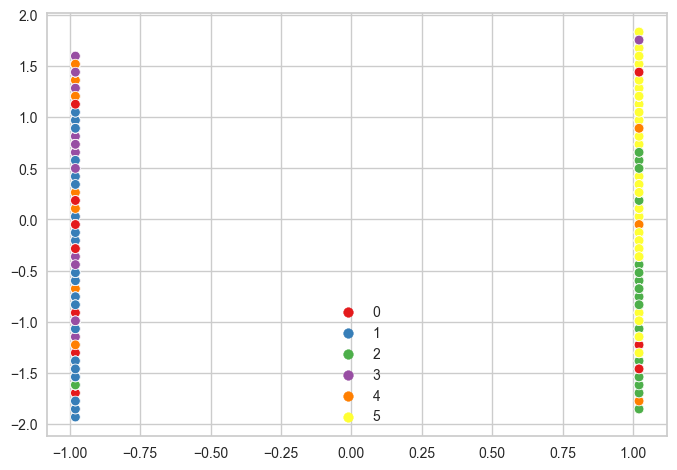

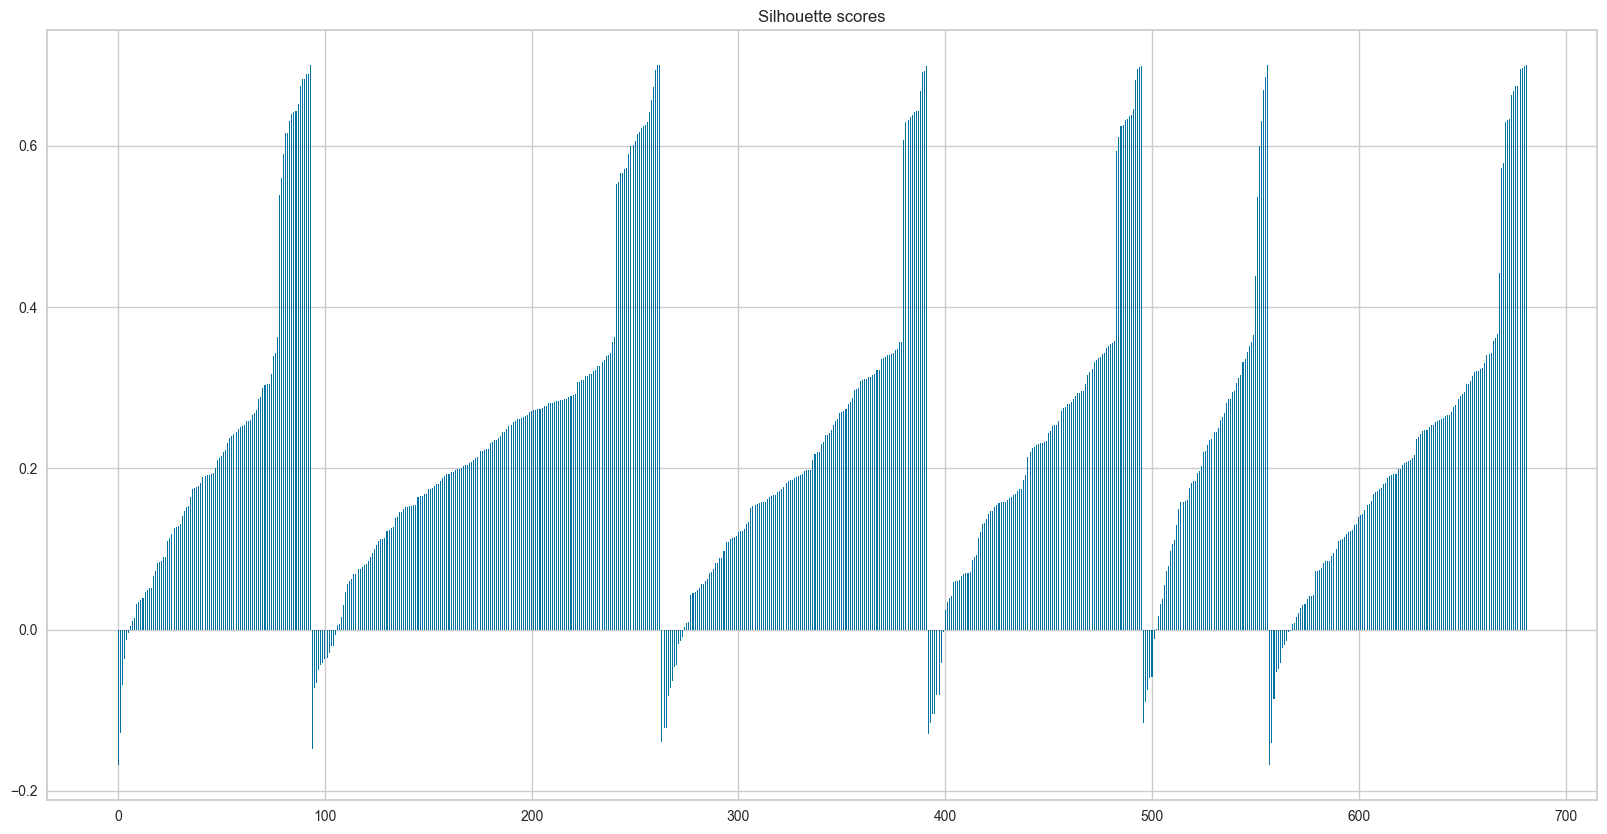

Average silhouette score: {0: 0.24067558148461582, 1: 0.24317521282375085, 2: 0.21503705480189544, 3: 0.23783502402242204, 4: 0.22668534232487714, 5: 0.21956021049089214}
Total average silhouette score: 0.23089086567114842
Variance Ratio Criterion: 166.5186893880754
Davies-Bouldin score: 1.6516848905883295
Using best k from silhouette method: 2


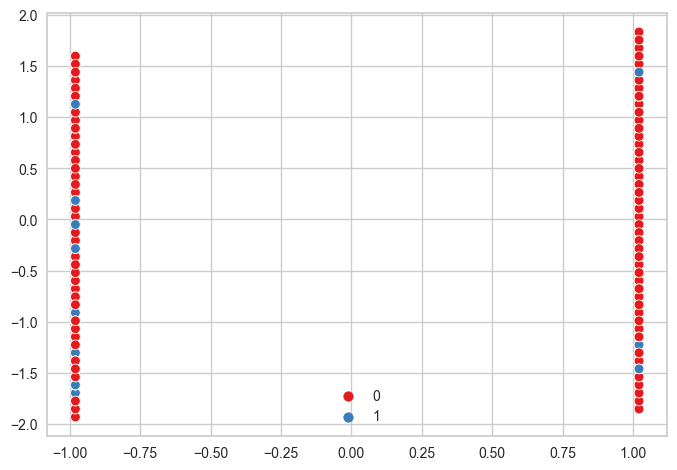

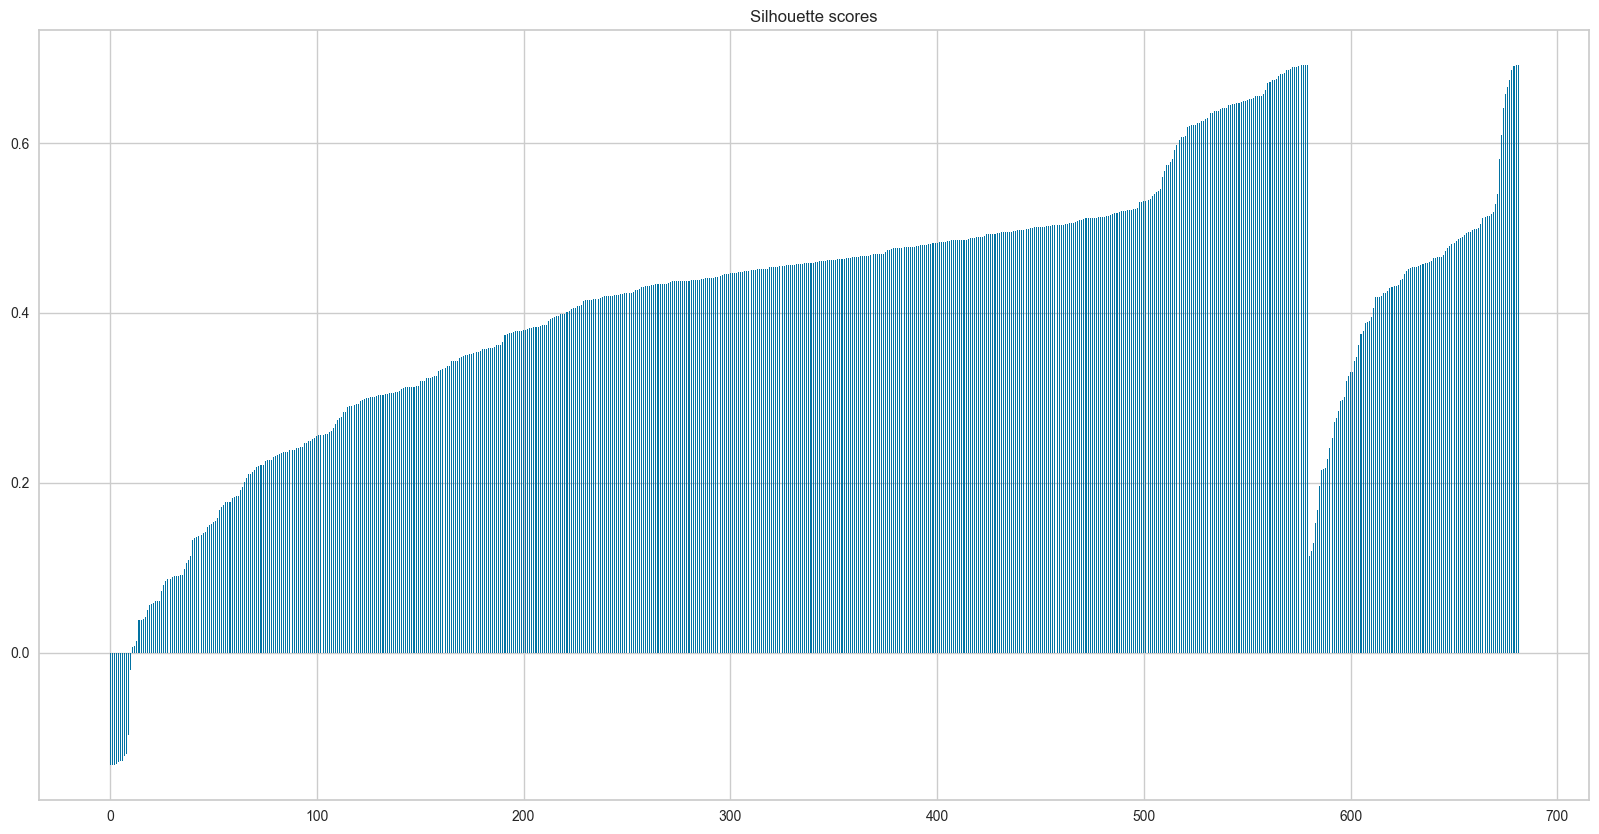

Average silhouette score: {0: 0.4034477751810648, 1: 0.429060006590027}
Total average silhouette score: 0.4072783435149565
Variance Ratio Criterion: 322.9588610355308
Davies-Bouldin score: 0.8730030284604473


In [257]:
use_model(KMedoids, {'method': 'pam', 'init': 'heuristic', 'max_iter': 300}, metric='euclidean')

In [258]:
# potential TODO other method. Significantly more complex, maybe not worth it
# DBSCAN(eps=0.5, min_samples=5, algorithm='auto', leaf_size=30, p=None, metric='euclidean', n_jobs=-1)

In [259]:
data

,Id,loan_date,loan_duration,loan_payments,Predicted,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,...,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent,owner_profile
0,5314,930705,12,8033,1.0,1,7,11.459651,15,13,...,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,45,3,0,1
1,5316,930711,36,4610,0.0,2,3,11.632565,48,20,...,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,24,4,0,1
2,6863,930728,60,2118,0.0,2,3,11.263399,85,19,...,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,57,5,0,1
3,5325,930803,36,2939,0.0,2,2,11.588682,84,29,...,41297.480000,8253.080000,9254.600000,7168.100000,1371.704000,0,53,6,0,1
4,7240,930906,60,4579,0.0,1,4,14.001951,0,0,...,57188.211111,18945.966667,21255.930769,16801.000000,1522.707407,1,14,6,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,4989,981205,48,7348,NaN,2,6,11.545848,87,16,...,30797.487500,8582.460714,8806.779310,8341.525926,538.846429,0,47,16,0,1
678,5221,981205,12,4376,NaN,2,0,11.964269,49,70,...,59684.298851,12491.751724,14839.705263,10670.889796,471.668966,1,53,17,0,1
679,6402,981206,24,5812,NaN,1,2,11.228332,55,26,...,46755.305769,13016.101923,17969.630769,10043.984615,461.121154,1,29,18,0,1
680,5346,981206,24,2318,NaN,2,1,12.561601,0,2,...,29645.320175,6040.260526,7270.390000,5079.221875,337.274561,1,49,21,0,1


account_district_ratio_urban_inhabitants  account_district_average_salary
1.000                                     9.436759                           84
                                          9.199987                           24
0.899                                     9.227886                           24
1.000                                     9.275472                           20
0.747                                     9.172015                           17
                                                                             ..
0.617                                     9.054154                            3
0.608                                     9.012865                            3
0.818                                     9.174713                            2
0.524                                     9.061840                            2
0.805                                     9.090092                            1
Length: 77, dtype: int64

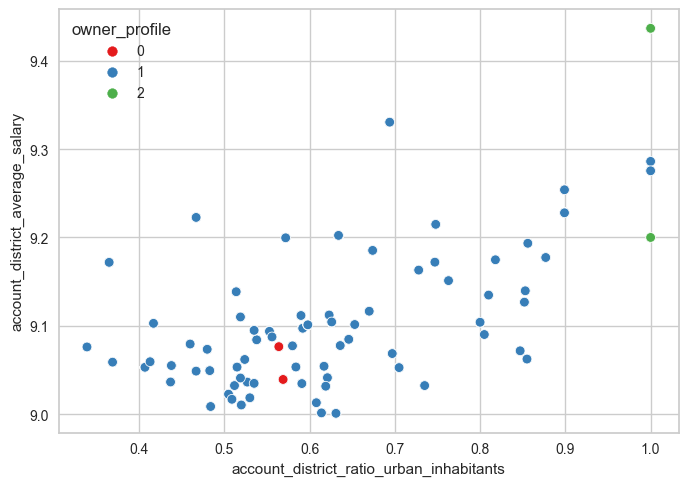

In [260]:
sns.scatterplot(data, x='account_district_ratio_urban_inhabitants', y='account_district_average_salary', hue='owner_profile', palette='Set1')
data[['account_district_ratio_urban_inhabitants', 'account_district_average_salary']].value_counts()

<AxesSubplot: >

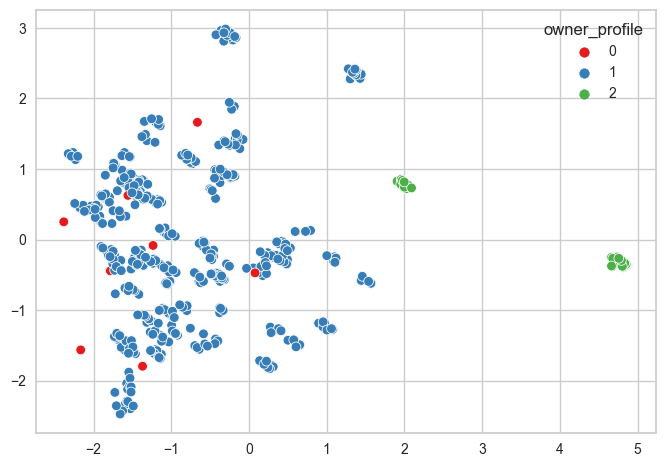

In [261]:
inputs = data[input_cols].values
scaler = StandardScaler().fit(inputs)
inputs = scaler.transform(inputs)

pca = PCA(n_components=2, random_state=random_state)
pca.fit(inputs)
inputs = pca.transform(inputs)
sns.scatterplot(x=inputs[:, 0], y=inputs[:, 1], hue=data['owner_profile'], palette='Set1')


In [262]:
data[['owner_profile', 'Predicted', ]].value_counts()

owner_profile  Predicted
1              0.0          233
2              0.0           46
1              1.0           37
2              1.0            9
0              0.0            3
dtype: int64

<AxesSubplot: >

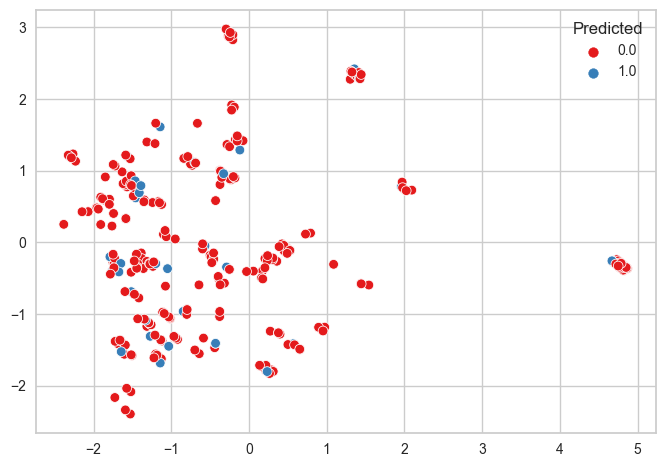

In [263]:
sns.scatterplot(x=inputs[:, 0], y=inputs[:, 1], hue=data['Predicted'], palette='Set1')

In [264]:
data.to_csv('output/loan_with_cluster.csv', index=False)